### Building the lipid

In [20]:
from openff.interchange import Interchange
from openff.toolkit import Molecule, ForceField, Topology
import numpy as np
import mdtraj
from openff.units import unit, Quantity

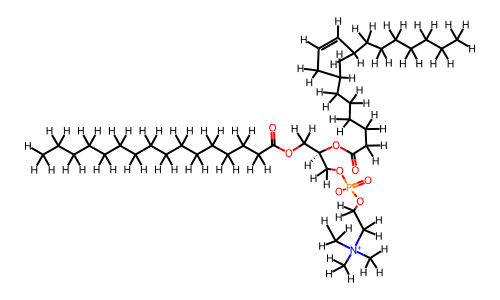

In [11]:
# Create a molecule from a SMILES string
# If missing stereochemistry, "allow_undefined_stereo=True"
lipid = Molecule.from_smiles("[C@](COP(=O)([O-])OCC[N+](C)(C)C)([H])(OC(CCCCCCC/C=C\CCCCCCCC)=O)COC(CCCCCCCCCCCCCCC)=O", allow_undefined_stereo=True)
lipid.visualize()

In [ ]:
# Define ff version | refer to this repo for updates and alternatives for water versions: https://github.com/openforcefield/openff-forcefields
forcefield = ForceField("openff-2.1.0.offxml")

# Lipid abbreviation used for structure file
lipid.name = "POPC"

# Replace resname and generate unique atom names by element frequency (C1, C2, C3...)
for i, atom in enumerate(lipid.atoms, 3):
    atom.metadata["residue_name"] = "POPC"
lipid.generate_unique_atom_names()
lipid.generate_conformers()

# Create Interchange topology
interchange = forcefield.create_interchange(lipid.to_topology())

# GROMACS output structure for Packmol
interchange.to_gromacs(prefix = "Inter_POPC", decimal = 3, hydrogen_mass = 3)

In [ ]:
forcefield = ForceField("openff-2.1.0.offxml")
lipid = Topology.from_pdb("bilayer.pdb", unique_molecules=[lipid,water])

### Building the water

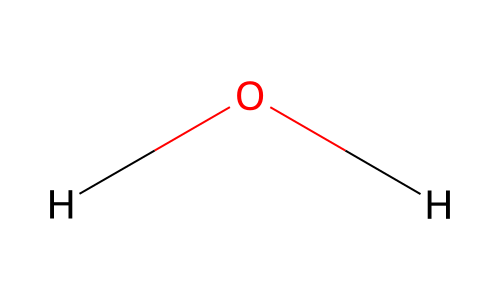

In [12]:
water = Molecule.from_smiles("O")
water.visualize()

In [ ]:
# Define ff version
forcefield = ForceField("tip3p.offxml")

water.name = "TIP3P"

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = "TIP3P"
water.generate_unique_atom_names()
water.generate_conformers()

interchange = forcefield.create_interchange(water.to_topology())

# PDB structure for Packmol
interchange.to_pdb("water.pdb")
interchange.to_top("water.top")

### Parametrize the system after Packmol

In [ ]:
# Define ff versions
forcefield = ForceField("openff-2.1.0.offxml", "tip3p.offxml")

# Atom count
topology = Topology.from_molecules(5120 * [water] + 128 * [lipid])

# Packmol bilayer to parametrize
path = mdtraj.load('bilayer.pdb')

# Topology designation given Packmol coordinates
topology.set_positions(path.xyz[0] * unit.nanometer)
topology.box_vectors = [7.5,7.5,9.0] * unit.nanometer

water.name = "TIP3P"
lipid.name = "POPC"

for i, atom in enumerate(lipid.atoms, 3):
    atom.metadata["residue_name"] = "POPC"
    lipid.generate_conformers()
    lipid.generate_unique_atom_names()
for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = "TIP3P"
    water.generate_conformers()
    water.generate_unique_atom_names(suffix = "w")

interchange = forcefield.create_interchange(topology)

interchange.to_gromacs(prefix = "bilayer", decimal = 3, hydrogen_mass = 3)

# Save before running